In [0]:
import copy
import time
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torch.nn as nn
import torch

In [0]:
def load_data(data_folder, batch_size, phase='train', train_val_split=True, train_ratio=.2):
    transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop(224),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}

    data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict[phase])

    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    data_size = {"train":train_size, "val":test_size}

    data_train, data_val = torch.utils.data.random_split(data, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True,
                                            num_workers=1)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False, drop_last=False,
                                        num_workers=1)
    dataloaders={"train":train_loader, "val":val_loader}
    return dataloaders, data_size


In [0]:
!unzip /content/pics.zip -d /content/data > /dev/null 2>&1 &

In [0]:
dataloaders, data_size = load_data("/content/data/pics", 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


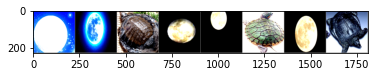

tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1) tensor(1)


In [5]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像の表示

imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(8)))

In [0]:
model = models.resnet18(pretrained=True)

In [0]:
for p in model.parameters():
    p.requires_grad=True
model.fc = nn.Linear(512, 2)

In [0]:
model = model.cuda()#GPUを使用しない場合はこの行はいらない。
lr = 1e-4
epoch = 40
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda() 

In [9]:
torch.cuda.is_available()

True

In [0]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict ={"train" : [],  "val" : []}
    acc_dict = {"train" : [],  "val" : []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                # else:
                #     inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)


            # サンプル数で割って平均を求める
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.item() / data_size[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict

In [11]:
model_ft, loss, acc = train_model(model, criterion, optim, num_epochs=epoch)

Epoch 0/40
----------
train Loss: 0.5977 Acc: 0.4643


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.2504 Acc: 0.9474
Epoch 1/40
----------
train Loss: 0.2041 Acc: 0.7857


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0911 Acc: 0.9825
Epoch 2/40
----------
train Loss: 0.0280 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0352 Acc: 0.9825
Epoch 3/40
----------
train Loss: 0.0384 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0228 Acc: 0.9912
Epoch 4/40
----------
train Loss: 0.0060 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0216 Acc: 0.9912
Epoch 5/40
----------
train Loss: 0.0046 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0121 Acc: 1.0000
Epoch 6/40
----------
train Loss: 0.0038 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0127 Acc: 1.0000
Epoch 7/40
----------
train Loss: 0.0254 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0123 Acc: 1.0000
Epoch 8/40
----------
train Loss: 0.0011 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0106 Acc: 1.0000
Epoch 9/40
----------
train Loss: 0.0014 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0121 Acc: 1.0000
Epoch 10/40
----------
train Loss: 0.0027 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0130 Acc: 1.0000
Epoch 11/40
----------
train Loss: 0.0799 Acc: 0.8214


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0148 Acc: 1.0000
Epoch 12/40
----------
train Loss: 0.0082 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0209 Acc: 1.0000
Epoch 13/40
----------
train Loss: 0.0492 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0255 Acc: 0.9912
Epoch 14/40
----------
train Loss: 0.0015 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0236 Acc: 1.0000
Epoch 15/40
----------
train Loss: 0.0018 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0175 Acc: 1.0000
Epoch 16/40
----------
train Loss: 0.0026 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0291 Acc: 0.9912
Epoch 17/40
----------
train Loss: 0.0041 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0189 Acc: 1.0000
Epoch 18/40
----------
train Loss: 0.0076 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0226 Acc: 0.9912
Epoch 19/40
----------
train Loss: 0.0351 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0279 Acc: 0.9912
Epoch 20/40
----------
train Loss: 0.0013 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0257 Acc: 0.9912
Epoch 21/40
----------
train Loss: 0.0436 Acc: 0.8214


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0451 Acc: 0.9825
Epoch 22/40
----------
train Loss: 0.0018 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0385 Acc: 0.9825
Epoch 23/40
----------
train Loss: 0.1118 Acc: 0.8214


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0383 Acc: 0.9825
Epoch 24/40
----------
train Loss: 0.0166 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0462 Acc: 0.9737
Epoch 25/40
----------
train Loss: 0.0022 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0591 Acc: 0.9825
Epoch 26/40
----------
train Loss: 0.0029 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0104 Acc: 0.9912
Epoch 27/40
----------
train Loss: 0.0012 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0232 Acc: 0.9825
Epoch 28/40
----------
train Loss: 0.0043 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0136 Acc: 0.9912
Epoch 29/40
----------
train Loss: 0.0098 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0126 Acc: 0.9912
Epoch 30/40
----------
train Loss: 0.0026 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0106 Acc: 1.0000
Epoch 31/40
----------
train Loss: 0.0028 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0109 Acc: 1.0000
Epoch 32/40
----------
train Loss: 0.0013 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0109 Acc: 1.0000
Epoch 33/40
----------
train Loss: 0.0922 Acc: 0.7857


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0096 Acc: 1.0000
Epoch 34/40
----------
train Loss: 0.0006 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0123 Acc: 0.9912
Epoch 35/40
----------
train Loss: 0.0019 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0241 Acc: 0.9825
Epoch 36/40
----------
train Loss: 0.0003 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0236 Acc: 0.9912
Epoch 37/40
----------
train Loss: 0.0005 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0086 Acc: 1.0000
Epoch 38/40
----------
train Loss: 0.0269 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0202 Acc: 0.9825
Epoch 39/40
----------
train Loss: 0.0047 Acc: 0.8571


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0158 Acc: 0.9912
Training complete in 0m 56s
Best val acc: 1.0000


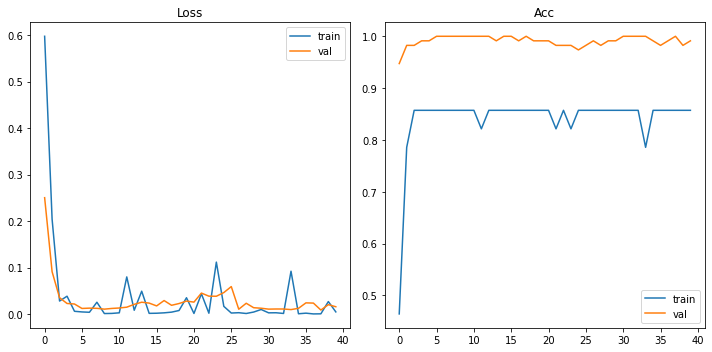

In [15]:
#loss, accを取り出します。
loss_train = loss["train"]
loss_val    = loss["val"]

acc_train = acc["train"]
acc_val    = acc["val"]


#このように書く事で、nrows x cols のグラフを作成する事ができます。
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#０個目のグラフ
axes[0].plot(range(epoch), loss_train, label = "train")
axes[0].plot(range(epoch), loss_val,    label =  "val")
axes[0].set_title("Loss")
axes[0].legend()#各グラフのlabelを表示

#１個目のグラフ
axes[1].plot(range(epoch), acc_train, label = "train")
axes[1].plot(range(epoch), acc_val,    label =  "val")
axes[1].set_title("Acc")
axes[1].legend()

#０個目と１個目のグラフが重ならないように調整
fig.tight_layout()


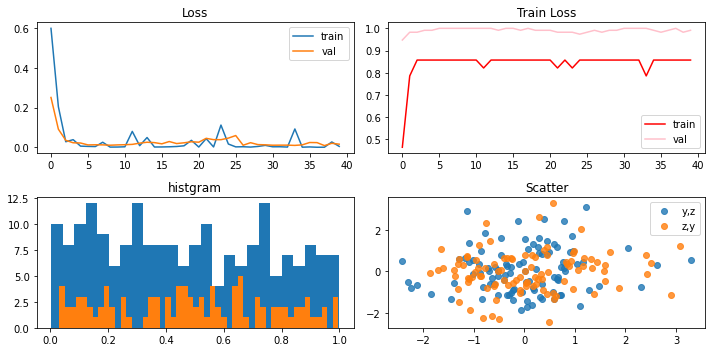

In [25]:
loss_train = loss["train"]
loss_val    = loss["val"]

acc_train = acc["train"]
acc_val    = acc["val"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axes[0,0].plot(range(epoch), loss_train, label = "train")
axes[0,0].plot(range(epoch), loss_val,    label =  "val")
axes[0,0].set_title("Loss")
axes[0,0].legend()

axes[0,1].plot(range(epoch), acc_train, c="red",  label = "train")
axes[0,1].plot(range(epoch), acc_val,    c="pink", label =  "val")
axes[0,1].set_title("Train Loss")
axes[0,1].legend()

x = np.random.rand(100)
xx = np.random.rand(200)
axes[1,0].hist(xx, bins=25, label="xx")
axes[1,0].hist(x, bins=50,   label="x")
axes[1,0].set_title("histgram")

y = np.random.randn(100)
z = np.random.randn(100)
axes[1,1].scatter(y, z, alpha=0.8, label="y,z") 
axes[1,1].scatter(z, y, alpha=0.8, label="z,y")
axes[1,1].set_title("Scatter")
axes[1,1].legend()

fig.tight_layout()

In [14]:
y

array([-1.73056025, -0.914501  ,  0.40750676,  1.57399546, -0.88876111,
        1.26434279, -0.66021591,  1.22571782, -0.56470821, -0.06990092,
       -1.9868527 , -0.69078942, -0.91380733,  0.2906317 ,  1.07092289,
        1.45721549,  0.01827156,  0.29306453,  2.37803684,  1.08714187,
       -0.93440547,  1.06115544,  1.94857641,  1.22374438,  0.57154784,
       -1.66034531,  0.74040895, -1.62828122,  0.1427106 ,  0.17190586,
        0.59282367, -0.23912574, -1.40708906, -0.27197408,  0.02305117,
        0.45597884, -0.28954692,  0.73526445, -0.8949195 , -1.09702754,
        1.16428911,  1.04504604,  0.87244613,  0.37521199, -0.80094634,
        0.78040246,  0.07034112, -1.38136298,  0.46188444, -1.27114563,
       -0.74206728, -0.45278045,  1.95810063, -0.4508313 ,  1.88139677,
        0.70187759, -1.52903695,  0.58679574, -0.07768516,  0.6975425 ,
       -0.51712571,  1.73010866,  0.16466539, -0.13947438, -0.78415087,
       -0.31682152, -0.61425003, -0.10576074,  0.40525641, -0.61